# 7.6. Convolutional Neural Networks (LeNet)
VIDE EXERCÍCIOS 4 E 5 PARA VISÃO GERAL.

Agora temos todos os ingredientes necessários para montar uma CNN totalmente funcional.

Em nosso encontro anterior com dados de imagem (dados Fashion-MNIST), aplicamos:

- Um modelo linear (para classificação) com regressão softmax (Seção 4.4) e
- um MLP ( Seção 5.2 ).

Para tornar esses dados acessíveis, primeiro achatamos (flatenning) cada imagem de 28x28 em um comprimento fixo 1x784 e depois os processamos em camadas totalmente conectadas.

- __Substituiremos as camadas totalmente conectadas por camadas convolucionais.__
  
Como um benefício adicional de substituir camadas totalmente conectadas por camadas convolucionais, desfrutaremos de modelos mais parcimoniosos que exigem muito menos parâmetros.

Nesta seção, apresentaremos o LeNet, entre as primeiras CNNs publicadas a capturar grande atenção por seu desempenho em tarefas de visão computacional.

Na época, o LeNet alcançou resultados excelentes, correspondendo ao desempenho de máquinas de vetores de suporte, então uma abordagem dominante em aprendizado supervisionado, alcançando uma taxa de erro de menos de 1% por dígito.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 7.6.1. Rede Le: LeNet (LeNet-5)

Em um alto nível, o LeNet (LeNet-5) consiste em duas partes: 

- (i) um codificador convolucional consistindo de duas camadas convolucionais; e 
- (ii) um bloco denso consistindo de três camadas totalmente conectadas. 

A arquitetura é resumida na Fig. 7.6.1 



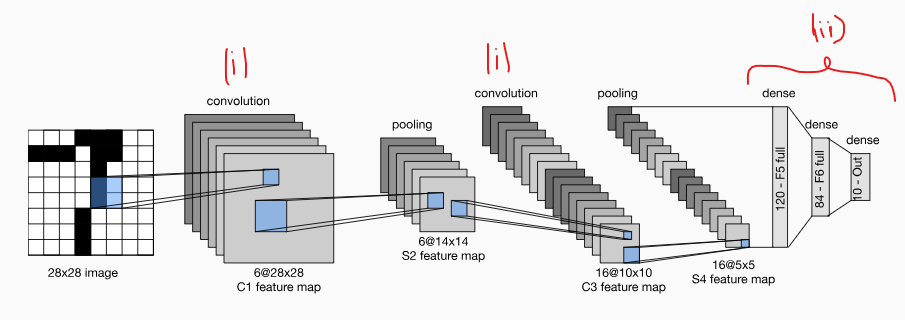
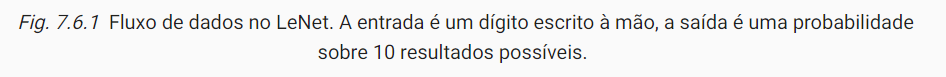
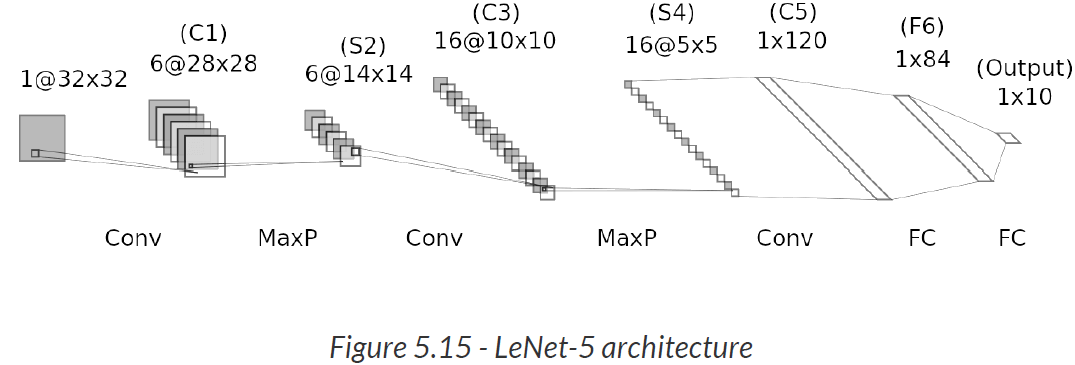

As unidades básicas em cada bloco convolucional são uma camada convolucional, uma função de ativação sigmoide e uma operação de pooling média subsequente. 

- __Observe que, embora ReLUs e max-pooling funcionem melhor, eles ainda não foram descobertos.__ 

- __Cada camada convolucional usa um kernel 5x5 e uma função de ativação sigmoide.__

O bloco denso do LeNet tem três camadas totalmente conectadas, com 120, 84 e 10 saídas, respectivamente. Como ainda estamos realizando a classificação, a camada de saída de 10 dimensões corresponde ao número de classes de saída possíveis.

__Embora chegar ao ponto em que você realmente entende o que está acontecendo dentro do LeNet possa ter dado um pouco de trabalho, esperamos que o seguinte trecho de código o convença de que implementar tais modelos com frameworks modernos de deep learning é notavelmente simples.__

Precisamos apenas instanciar um bloco Sequential e encadear as camadas apropriadas, usando a inicialização Xavier conforme introduzido na Seção 5.4.2.2.



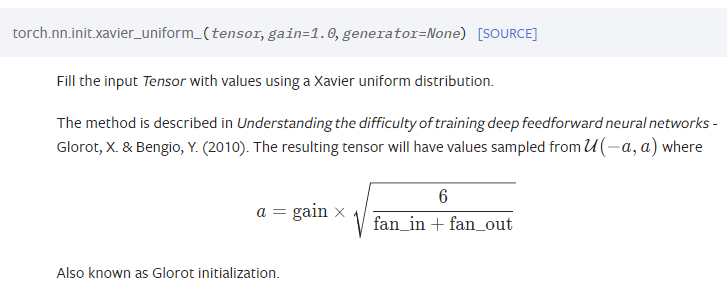

5.1.2. Funções de ativação

As funções de ativação decidem se um neurônio deve ser ativado ou não, calculando a soma ponderada e adicionando viés a ele.

Eles são operadores diferenciáveis para transformar sinais de entrada em saídas, enquanto a maioria deles adiciona não linearidade.

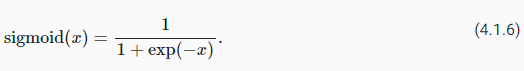

In [3]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

class LeNet(d2l.Classifier):                      # Cria a arquitetura da rede
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(), # Convolução + Sigmoid (Função de ativação --> aplica não linearidade)
            nn.AvgPool2d(kernel_size=2, stride=2), # Pooling=agrupamento Avg(médio). Max pooling não existia.                        
            nn.LazyConv2d(out_channels=16, kernel_size=5), nn.Sigmoid(), # Convolução + Sigmoid (Função de ativação --> aplica não linearidade)
            nn.AvgPool2d(kernel_size=2, stride=2), # Pooling=agrupamento Avg(médio). Max pooling não existia. 
            nn.Flatten(), # Achatamento: 1x400: 16x(5x5)
            nn.LazyLinear(120), nn.Sigmoid(), # 1x120 + Função de ativação
            nn.LazyLinear(84), nn.Sigmoid(),  # 1x84  + Função de ativação
            nn.LazyLinear(num_classes))       # num_classes = 10


# LeNet(
#   (net): Sequential(
#     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (1): Sigmoid()
#     (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
#     (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
#     (4): Sigmoid()
#     (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
#     (6): Flatten(start_dim=1, end_dim=-1)
#     (7): Linear(in_features=400, out_features=120, bias=True)
#     (8): Sigmoid()
#     (9): Linear(in_features=120, out_features=84, bias=True)
#     (10): Sigmoid()
#     (11): Linear(in_features=84, out_features=10, bias=True)
#   )
# )

Tomamos alguma liberdade na reprodução do LeNet na medida em que substituímos a camada de ativação gaussiana por uma camada softmax(*). Isso simplifica muito a implementação, principalmente devido ao fato de que o decodificador gaussiano raramente é usado hoje em dia. Fora isso, essa rede corresponde à arquitetura original do LeNet-5.

(*) Sigmoids are still widely used as activation functions on the output units when we want to interpret the outputs as probabilities for binary classification problems: __you can think of the sigmoid as a special case of the softmax.__

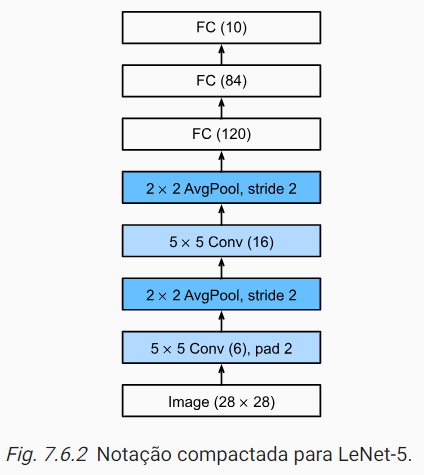

Vamos ver o que acontece dentro da rede. Passando um canal único (preto e branco) 28x28 através da rede e imprimindo a forma de saída em cada camada, podemos inspecionar o modelo para garantir que suas operações estejam alinhadas com o que esperamos da Fig. 7.6.2 .

In [9]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [7]:
for layer in model.net:
        print(layer)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Sigmoid()
AvgPool2d(kernel_size=2, stride=2, padding=0)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=400, out_features=120, bias=True)
Sigmoid()
Linear(in_features=120, out_features=84, bias=True)
Sigmoid()
Linear(in_features=84, out_features=10, bias=True)


Note que a altura e a largura da representação em cada camada ao longo do bloco convolucional são reduzidas (comparado com a camada anterior). 

- A primeira camada convolucional usa dois pixels de preenchimento (padding=(2, 2)) para compensar a redução na altura e largura que, de outra forma, resultaria do uso de um kernel 5x5.
- Em contraste, a segunda camada convolucional renuncia ao preenchimento e, portanto, a altura e a largura são reduzidas em quatro pixels.
-  À medida que subimos na pilha de camadas, o número de canais aumenta camada sobre camada de 1 na entrada para 6 após a primeira camada convolucional e 16 após a segunda camada convolucional. No entanto, cada camada de agrupamento reduz pela metade a altura e a largura.
-  Finalmente, cada camada totalmente conectada reduz a dimensionalidade, finalmente emitindo uma saída cuja dimensão corresponde ao número de classes.

# 7.6.2. Treinamento

Agora que implementamos o modelo, vamos executar um experimento para ver como o modelo LeNet-5 se sai no Fashion-MNIST.

- Embora CNNs tenham menos parâmetros, eles ainda podem ser mais caros para computar do que MLPs profundos semelhantes porque cada parâmetro participa de muito mais multiplicações. Se você tiver acesso a uma GPU, este pode ser um bom momento para colocá-la em ação para acelerar o treinamento.

- Observe que a d2l.Trainer classe cuida de todos os detalhes. Por padrão, ela inicializa os parâmetros do modelo nos dispositivos disponíveis.

- Assim como com MLPs, nossa função de perda é de __entropia cruzada__, e a minimizamos por meio da __descida de gradiente estocástico__ do minibatch.

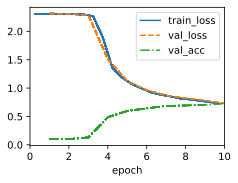

In [11]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

In [18]:
# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: treinar com gpu e transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))
print(y_hat)

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------


tensor([[ -6.1892, -10.5630,  -3.1385,  ...,   5.7191,   4.3651,   7.7953],
        [  2.5564,  -3.4749,   4.9617,  ...,  -7.3883,   2.4361,  -4.3173],
        [  4.2336,   5.6621,   1.5137,  ...,  -6.3577,  -3.0851,  -7.7555],
        ...,
        [  2.5988,   0.1360,   3.5128,  ...,  -7.2404,   0.5308,  -6.3817],
        [  2.7928,   7.8605,  -0.8655,  ...,  -3.3964,  -4.5736,  -7.1717],
        [ -4.2721, -10.4990,   0.2667,  ...,   0.4786,   7.3887,   2.2046]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
acc: 0.45


# Código Agrupado

tensor([[ -6.9015,  -9.4010,  -2.3160,  ...,   5.6314,   4.4062,   6.8868],
        [  2.6878,  -4.9431,   5.2037,  ...,  -8.6872,   2.7887,  -6.0768],
        [  2.3091,   5.5001,  -0.0341,  ...,  -5.9774,  -5.4666,  -3.6494],
        ...,
        [  2.5565,  -2.1668,   3.0667,  ...,  -7.8692,   0.4413,  -4.9467],
        [  1.4411,   6.0897,  -1.2981,  ...,  -4.7137,  -5.9063,  -2.3535],
        [ -4.3790, -10.4255,   0.7981,  ...,   0.9449,   6.9574,   0.8358]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
acc: 0.52


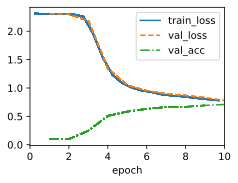

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):                      # Cria a arquitetura da rede
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(), # Convolução + Sigmoid (Função de ativação --> aplica não linearidade)
            nn.AvgPool2d(kernel_size=2, stride=2), # Pooling=agrupamento Avg(médio). Max pooling não existia.                        
            nn.LazyConv2d(out_channels=16, kernel_size=5), nn.Sigmoid(), # Convolução + Sigmoid (Função de ativação --> aplica não linearidade)
            nn.AvgPool2d(kernel_size=2, stride=2), # Pooling=agrupamento Avg(médio). Max pooling não existia. 
            nn.Flatten(), # Achatamento: 1x400: 16x(5x5)
            nn.LazyLinear(120), nn.Sigmoid(), # 1x120 + Função de ativação
            nn.LazyLinear(84), nn.Sigmoid(),  # 1x84  + Função de ativação
            nn.LazyLinear(num_classes))       # num_classes = 10
# Sigmoid é um caso especial de softmax.
# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: treinar com gpu e transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))
print(y_hat)

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------



# Resumo

Fizemos um progresso significativo neste capítulo. Passamos dos MLPs da década de 1980 para os CNNs da década de 1990 e início dos anos 2000. As arquiteturas propostas, por exemplo, na forma de LeNet-5 permanecem significativas, até hoje.

Uma das principais diferenças, como veremos, é que maiores quantidades de computação permitiram arquiteturas significativamente mais complexas.

Uma segunda diferença é a relativa facilidade com que conseguimos implementar o LeNet. O que costumava ser um desafio de engenharia que valia meses de código C++ e assembly e, finalmente, experimentação com modelos agora pode ser realizada em minutos.


In [14]:
# - Função para inicialização:     Xavier
# - Cria a arquitetura da rede:    LeNet - Convolucional 
# ----------------------------
# - Função de perda:               Entropia Cruzada
# - Minimização da perda:          Descida de Gradiente Estocástico (SGD - Stochastic Gradient Descent)
# ----------------------------
# - trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
# - data = d2l.FashionMNIST(batch_size=128)                                    # dados
# - model = LeNet(lr=0.1)                                                      # modelo
# - model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
# - trainer.fit(model, data)                                                   # início do treinamento

# Referências

https://sci-hub.se/10.1162/neco.1989.1.4.541

https://sci-hub.se/10.1109/5.726791


# Exercícios

# Ex. 1 - Vamos modernizar o LeNet. Implementar e testar as seguintes mudanças:

- Substitua o pooling médio pelo pooling máximo.

acc: 0.63


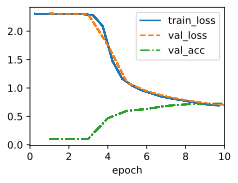

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------


- Substitua a camada softmax por ReLU.

Sigmoid é um caso especial de Softmax. Desta forma, deve ser substituido o Sigmoid() por ReLU().

acc: 0.86


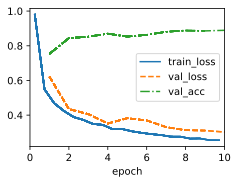

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------


As substituições realizadas melhoraram a acurácia da rede:
- pooling médio pelo pooling máximo;
- camada softmax por ReLU;



# Ex. 2 - Tente alterar o tamanho da rede no estilo LeNet para melhorar sua precisão, além do max-pooling e do ReLU.

- Ajuste o tamanho da janela de convolução.

acc: 0.82


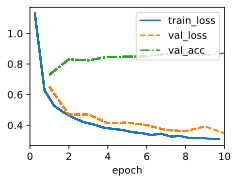

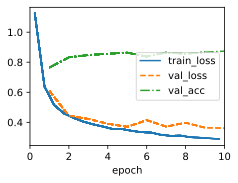

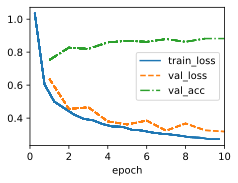

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10, c1=1, c2=1, c3=1, c4=1, c5=1, c6=1):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size=c2, padding=c3), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(c4, kernel_size=c5, padding=c6), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                              # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados

      
conv = [
    [[6,10,2],[16,5,0]],     # kernel1 = 10; kernel2 = 5
    [[6,5,2],[16,10,0]],     # kernel1 = 5; kernel2 = 10
    [[6,2,2],[16,2,0]]       # kernel1 = 2; kernel2 = 2
]
acuracia = []

for i in range(3):
    model = LeNet(lr=0.1, c1=conv[i][0][0], c2=conv[i][0][1], c3=conv[i][0][2], c4=conv[i][1][0], c5=conv[i][1][1], c6=conv[i][1][2])                                                      # modelo

    model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
    trainer.fit(model, data)                                                   # início do treinamento
    
    # ------------------------------------------------------------------------------------
    # PEGAR y_hat e imprimir acc:
    # ------------------------------------------------------------------------------------
    # SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
    # y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
    # print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
    # ------------------------------------------------------------------------------------
    # SOLUÇÃO 2: transferir o dataset para a GPU.
    
    # Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
    def get_default_device():
        """Pick GPU if available, else CPU"""
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    device = get_default_device()              # dispositivo utilizado
    
    # Transfere 'data' para 'device'
    def to_device(data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
    y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))
    
    targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
    acura = model.accuracy(y_hat,targets2).item()
    print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
   
    acuracia.append(acura)
# ------------------------------------------------------------------------------------  

In [10]:
acuracia

[0.8139999508857727, 0.8514999747276306, 0.8174999952316284]

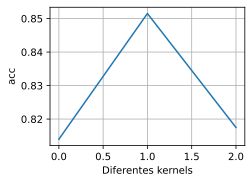

In [12]:
d2l.plot(list(range(len(acuracia))),acuracia,'Diferentes kernels','acc')
# conv = [
#     [[6,10,2],[16,5,0]],     # kernel1 = 10; kernel2 = 5
#     [[6,5,2],[16,10,0]],     # kernel1 = 5; kernel2 = 10
#     [[6,2,2],[16,2,0]]       # kernel1 = 2; kernel2 = 2
# ]

# - Ajuste o número de canais de saída.

Rodei no Google Colab por excassez de memória. O treinamento requer mais de 2.0 Gb de RAM.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10, c1=1, c2=1, c3=1, c4=1, c5=1, c6=1):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size=c2, padding=c3), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(c4, kernel_size=c5, padding=c6), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                              # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados

      
conv = [
    [[16,5,2],[32,5,0]],    # out_channels1 = 16; out_channels2 = 32
    [[6,5,2],[16,5,0]],     # out_channels1 = 6;  out_channels2 = 16
    [[2,5,2],[8,5,0]]       # out_channels1 = 2;  out_channels2 = 8
]
acuracia = []

for i in range(3):
    model = LeNet(lr=0.1, c1=conv[i][0][0], c2=conv[i][0][1], c3=conv[i][0][2], c4=conv[i][1][0], c5=conv[i][1][1], c6=conv[i][1][2])                                                      # modelo

    model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
    trainer.fit(model, data)                                                   # início do treinamento
    
    # ------------------------------------------------------------------------------------
    # PEGAR y_hat e imprimir acc:
    # ------------------------------------------------------------------------------------
    # SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
    # nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
    # nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            
    # ------------------------------------------------------------------------------------
#    # SOLUÇÃO 2: transferir o dataset para a GPU.
    
    # Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
    def get_default_device():
        """Pick GPU if available, else CPU"""
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    device = get_default_device()              # dispositivo utilizado
    
    # Transfere 'data' para 'device'
    def to_device(data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
    y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))
    
    targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
    acura = model.accuracy(y_hat,targets2).item()
    print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
   
    acuracia.append(acura)
# # ------------------------------------------------------------------------------------  

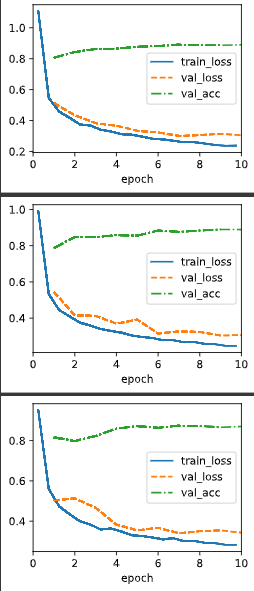

In [ ]:
acuracia

[0.8587999939918518, 0.8184999823570251, 0.851099967956543]

In [ ]:
d2l.plot(list(range(len(acuracia))),acuracia,'Out_channels','acc')

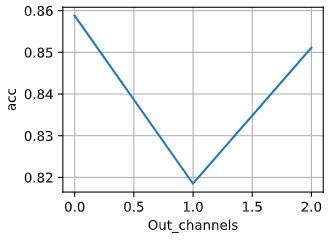

# - Ajuste o número de camadas totalmente conectadas

In [35]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),     # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(20, kernel_size=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            
            nn.LazyConv2d(5, kernel_size=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
                        
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 20, 13, 13])
ReLU output shape:	 torch.Size([1, 20, 13, 13])
MaxPool2d output shape:	 torch.Size([1, 20, 6, 6])
Conv2d output shape:	 torch.Size([1, 5, 5, 5])
ReLU output shape:	 torch.Size([1, 5, 5, 5])
MaxPool2d output shape:	 torch.Size([1, 5, 2, 2])
Flatten output shape:	 torch.Size([1, 20])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


acc: 0.72


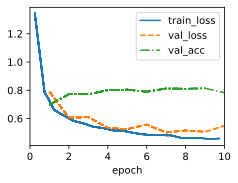

In [36]:
# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------

# - Ajuste as taxas de aprendizado e outros detalhes de treinamento (por exemplo, inicialização e número de épocas).

acc: 0.31


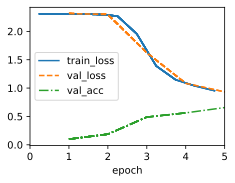

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_normal_(module.weight)                        #  MUDANÇA DE XAVIER UNIFORME PARA NORMAL

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.01, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=5, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------


# Ex. 3 - Experimente a rede aprimorada no conjunto de dados MNIST original.

Os melhores resultados de aprimoramento de rede foram obtidos com:

- Substitua o pooling médio pelo pooling máximo.
- Substitua a camada softmax (sigmoid) por ReLU.

Sigmoid é um caso especial de Softmax. Desta forma, deve ser substituido o Sigmoid() por ReLU().

In [54]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)


# ------------------------------------------------------------------------------------

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [55]:
###########################################################################
# Utilizando @d2l.add_to_class(d2l) para adicionar a classe MNIST a biblioteca d2l.
# A classe MNIST é uma cópia modificada da classe FashionMNIST.

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

@d2l.add_to_class(d2l) 
class MNIST(d2l.DataModule):
    """The Fashion-MNIST dataset.

    Defined in :numref:`sec_fashion_mnist`"""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels.
    
        Defined in :numref:`sec_fashion_mnist`"""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=self.num_workers)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

data = d2l.MNIST(batch_size=128)

acc: 0.99


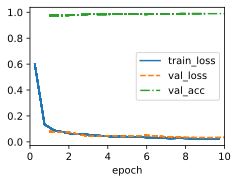

In [56]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------

# Ex. 4 - Exiba as ativações da primeira e segunda camadas do LeNet para diferentes entradas (por exemplo, suéteres e casacos).

FIZ PARA TODAS AS CAMADAS

acc: 0.82


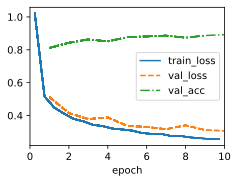

In [57]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------


array([<Axes: >, <Axes: >], dtype=object)

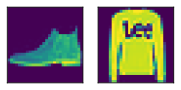

In [85]:
# Pega as duas primeiras linhas de data.val.data
# Converte para torch.float32
# unsqueeze insere a dimensão unitária em local específico (posição 1).
pic0 = data.val.data[:2,:].type(torch.float32).unsqueeze(dim=1)
img0 = pic0.squeeze().cpu()                                           # squeeze retira a dimensão unitária do tensor
d2l.show_images(img0, num_rows=1, num_cols=2)                                   

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

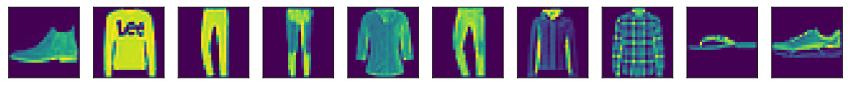

In [84]:
pic1 = data.val.data[0:10,:].type(torch.float32).unsqueeze(dim=1)  # 10 primeiros
img1 = pic1.squeeze().cpu()                                        # squeeze retira a dimensão unitária do tensor
d2l.show_images(img1, num_rows=1, num_cols=10) 

In [ ]:
import matplotlib.pyplot as plt

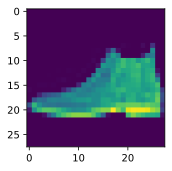

In [89]:
# Pega as duas primeiras linhas de data.val.data
# Converte para torch.float32
# unsqueeze insere a dimensão unitária em local específico (posição 1).
pic = data.val.data[0,:].type(torch.float32).unsqueeze(dim=0)
img = pic.squeeze().cpu()                                         # squeeze retira a dimensão unitária do tensor
plt.imshow(img)                                 

------------------------------------------

In [73]:
model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [74]:
model.net[0]

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

array([<Axes: >, <Axes: >], dtype=object)

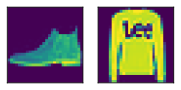

In [97]:
# Pega as duas primeiras linhas de data.val.data
# Converte para torch.float32
# unsqueeze insere a dimensão unitária em local específico (posição 1).
pic0 = data.val.data[:2,:].type(torch.float32).unsqueeze(dim=1)
img0 = pic0.squeeze().cpu()                                           # squeeze retira a dimensão unitária do tensor
d2l.show_images(img0, num_rows=1, num_cols=2)                                   

torch.Size([2, 1, 14, 14])

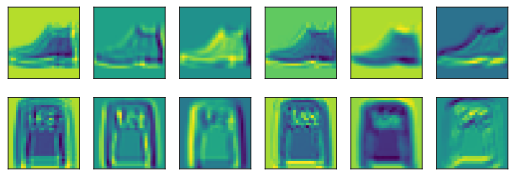

In [120]:
pic1 = model.net[0](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(-1,28,28),2,6)
imge.shape

-------------------------------

In [101]:
model.net[1]

ReLU()

torch.Size([2, 1, 14, 14])

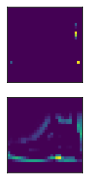

In [121]:
pic2 = model.net[1](pic1.cuda())
d2l.show_images(pic2.cpu().reshape(-1,28,28),2,1)
imge.shape

-------------------------------------------

In [104]:
model.net[2]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

torch.Size([2, 1, 14, 14])

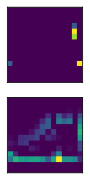

In [122]:
pic3 = model.net[2](pic2.cuda())
d2l.show_images(pic3.cpu().reshape(-1,14,14),2,1)
imge.shape

--------------------

In [115]:
model.net[3]

Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

torch.Size([2, 1, 14, 14])

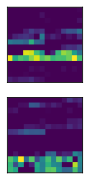

In [123]:
pic4 = model.net[2](pic3.cuda())
d2l.show_images(pic4.cpu().reshape(-1,14,14),2,1)
imge.shape

-----------------------------------

------------------------

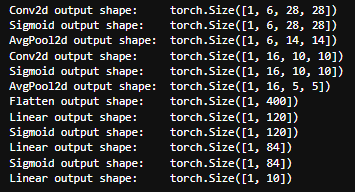

In [129]:
 model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

torch.Size([2, 6, 28, 28])

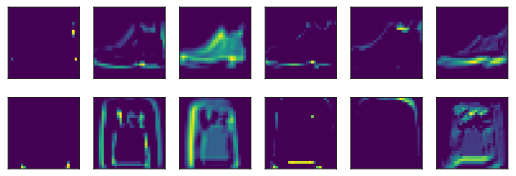

In [148]:
# Duas primeiras camadas consecutivas
pic1 = model.net[:2](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(12,28,28),2,6)   # 2 imagens de 16@10x10
pic1.shape      # Shape de Saída.

torch.Size([2, 6, 14, 14])

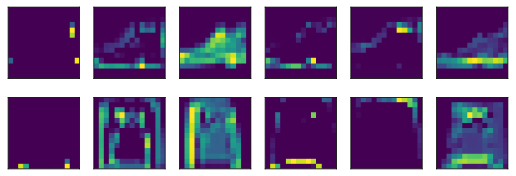

In [153]:
# Três primeiras camadas consecutivas
pic1 = model.net[:3](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(12,14,14),2,6)   # 2 imagens de 16@10x10
pic1.shape      # Shape de Saída.

torch.Size([2, 16, 10, 10])

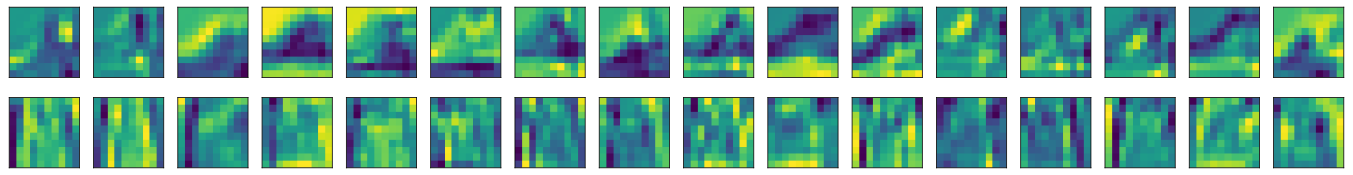

In [149]:
# Quatro primeiras camadas consecutivas
pic1 = model.net[:4](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(32,10,10),2,16)   # 2 imagens de 16@10x10
pic1.shape      # Shape de Saída.

torch.Size([2, 16, 10, 10])

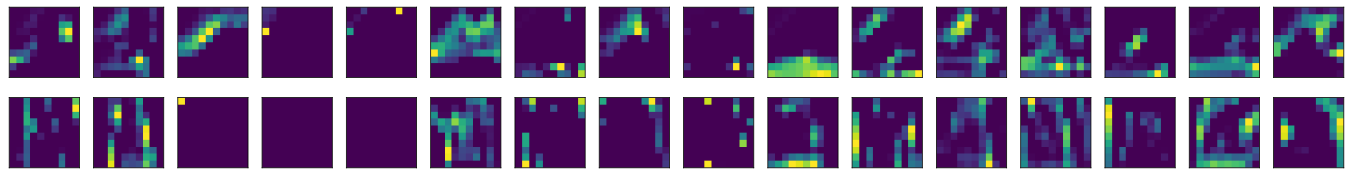

In [150]:
# Cinco primeiras camadas consecutivas
pic1 = model.net[:5](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(32,10,10),2,16)   # 2 imagens de 16@10x10
pic1.shape      # Shape de Saída.

torch.Size([2, 16, 5, 5])

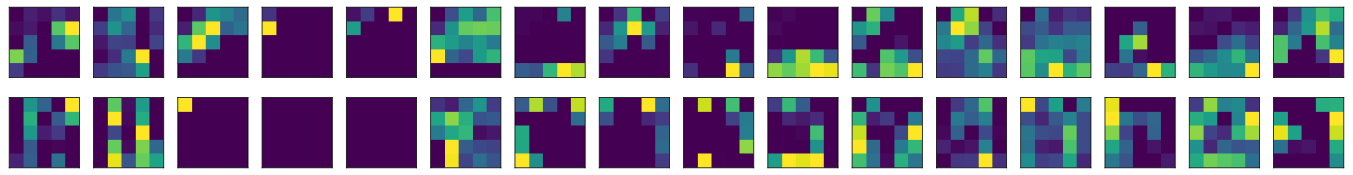

In [154]:
# Seis primeiras camadas consecutivas
pic1 = model.net[:6](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(32,5,5),2,16)   # 2 imagens de 16@10x10
pic1.shape      # Shape de Saída.

torch.Size([2, 400])

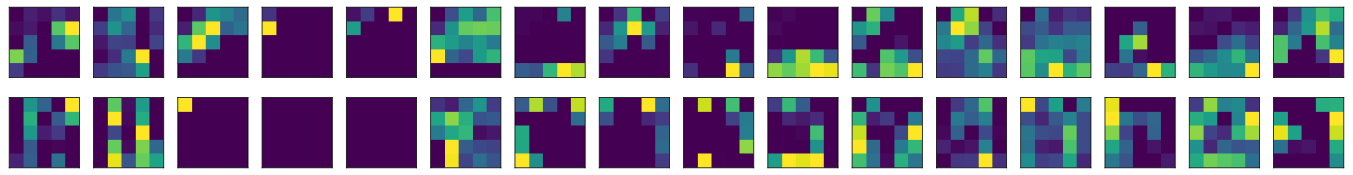

In [164]:
# Sete primeiras camadas consecutivas
pic1 = model.net[:7](pic0.cuda())
d2l.show_images(pic1.cpu().reshape(32,5,5),2,16)   # 2 imagens de 16@10x10
pic1.shape    # Shape de Saída. Flatten realizado. 

In [167]:
# Oito primeiras camadas consecutivas
pic1 = model.net[:8](pic0.cuda())
pic1.shape   # Shape de Saída.

torch.Size([2, 120])

In [168]:
# Nove primeiras camadas consecutivas
pic1 = model.net[:9](pic0.cuda())
pic1.shape   # Shape de Saída.

torch.Size([2, 120])

In [169]:
# Dez primeiras camadas consecutivas
pic1 = model.net[:10](pic0.cuda())
pic1.shape   # Shape de Saída.

torch.Size([2, 84])

In [170]:
# Onze primeiras camadas consecutivas
pic1 = model.net[:11](pic0.cuda())
pic1.shape   # Shape de Saída.

torch.Size([2, 84])

In [171]:
# Doze primeiras camadas consecutivas
pic1 = model.net[:12](pic0.cuda())
pic1.shape   # Shape de Saída.

torch.Size([2, 10])

In [172]:
pic1

tensor([[  -54.1355,  -483.2347,  -387.2785,  -430.6830,  -491.9930,   513.3273,
          -284.6343,   237.5774,   155.0795,  1179.5236],
        [  593.4534,  -787.6512,  2143.4089,  -444.2923,  1416.0027, -1447.4622,
           709.5688, -1210.5481,  -492.1424,  -825.3711]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

labels_map = { \
    0: "T-Shirt", \
    1: "Trouser",\
    2: "Pullover",\
    3: "Dress",\
    4: "Coat",\
    5: "Sandal",\
    6: "Shirt",\
    7: "Sneaker",\
    8: "Bag",\
    9: "Ankle Boot",


    tensor([[  -54.1355,  -483.2347,  -387.2785,  -430.6830,  -491.9930,   513.3273,
          -284.6343,   237.5774,   155.0795,  1179.5236 (MAIOR = 9 = Ankle Boot)],
          
        [  593.4534,  -787.6512,  2143.4089 (MAIOR = 2 = Pullover),  -444.2923,  1416.0027, -1447.4622,
           709.5688, -1210.5481,  -492.1424,  -825.3711]], device='cuda:0',
       grad_fn=<AddmmBackward0

Portanto, a primeira figura foi classificada como Ankle Boot (bota de cano curto) e a segunda como um Pullover (blusa de frio). A classificação foi correta.

In [290]:
# TODAS AS CAMADAS
saida = model.net(pic0.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.
saida

tensor([[  -54.1355,  -483.2347,  -387.2785,  -430.6830,  -491.9930,   513.3273,
          -284.6343,   237.5774,   155.0795,  1179.5236],
        [  593.4534,  -787.6512,  2143.4089,  -444.2923,  1416.0027, -1447.4622,
           709.5688, -1210.5481,  -492.1424,  -825.3711]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [176]:
pic0.shape

torch.Size([2, 1, 28, 28])

In [292]:
# ------------------------------------------------------------------------------------
# CLASSIFICA A IMAGEM CONFORME A SAÍDA.
# PRIMEIRA SAÍDA: saida[0]
m = saida[0].max()                                        # saída máxima
idx_tensor = (saida==m).nonzero(as_tuple=True)[1]      # índice do tensor
indice = int(idx_tensor)                               # converte tensor para inteiro

list_chaves = []                                       # cria lista vazia
classificadores = data.val.class_to_idx                # dicionário de classificação do FashionMNIST
chaves = classificadores.keys()                        # Chaves do dicionário
for chave in chaves:    
    list_chaves.append(chave)                          # Coloca as chaves em uma lista
classificacao = list_chaves[indice]                    # Busca o indice na lista
classificacao
# ------------------------------------------------------------------------------------

'Ankle boot'

In [293]:
# ------------------------------------------------------------------------------------
# CLASSIFICA A IMAGEM CONFORME A SAÍDA.
# SEGUNDA SAÍDA: saida[1]
m = saida[1].max()                                        # saída máxima
idx_tensor = (saida==m).nonzero(as_tuple=True)[1]      # índice do tensor
indice = int(idx_tensor)                               # converte tensor para inteiro

list_chaves = []                                       # cria lista vazia
classificadores = data.val.class_to_idx                # dicionário de classificação do FashionMNIST
chaves = classificadores.keys()                        # Chaves do dicionário
for chave in chaves:    
    list_chaves.append(chave)                          # Coloca as chaves em uma lista
classificacao = list_chaves[indice]                    # Busca o indice na lista
classificacao
# ------------------------------------------------------------------------------------

'Pullover'

# Para apenas 1 figura

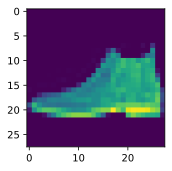

In [285]:
# Pega as duas primeiras linhas de data.val.data
# Converte para torch.float32
# unsqueeze insere a dimensão unitária em local específico (posição 1).
pic = data.val.data[0,:].type(torch.float32).unsqueeze(dim=0)
img = pic.squeeze().cpu()                                         # squeeze retira a dimensão unitária do tensor
plt.imshow(img)  
# d2l.show_images(img, num_rows=1, num_cols=1)   # Serve apenas para plotar uma lista de imagens.

In [265]:
pic


tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
     

In [186]:
pic.shape

torch.Size([1, 28, 28])

In [192]:
model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [237]:
pic.shape

torch.Size([1, 28, 28])

In [239]:
pic.unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

torch.Size([6, 28, 28])

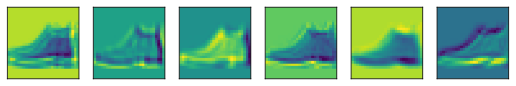

In [242]:
# Primeira camada
saida = model.net[0](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,28,28),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([6, 28, 28])

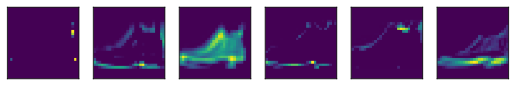

In [243]:
# Duas primeiras camadas
saida = model.net[:2](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,28,28),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([6, 14, 14])

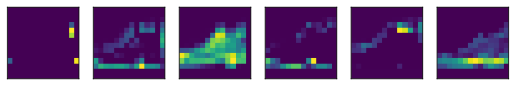

In [244]:
# Três primeiras camadas
saida = model.net[:3](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,14,14),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 10, 10])

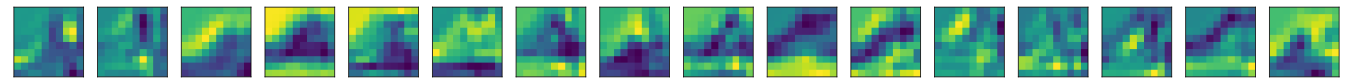

In [245]:
# Quatro primeiras camadas
saida = model.net[:4](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,10,10),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 10, 10])

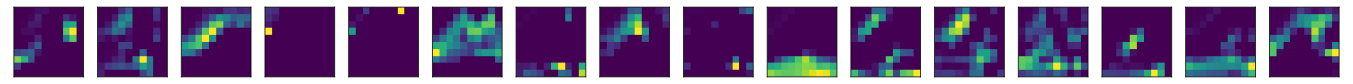

In [246]:
# Cinco primeiras camadas
saida = model.net[:5](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,10,10),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 5, 5])

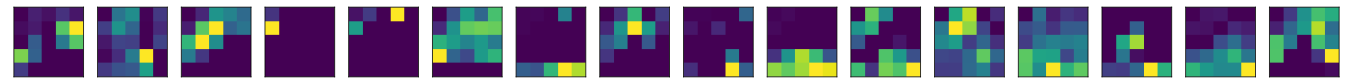

In [247]:
# Seis primeiras camadas
saida = model.net[:6](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,5,5),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([1, 1, 400])

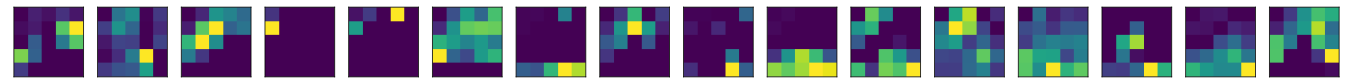

In [255]:
# Sete primeiras camadas
# saida = model.net[:7](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net[:7](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,5,5),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.
saida.unsqueeze(dim=0).shape

In [257]:
# Oito primeiras camadas
saida = model.net[:8](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 120])

In [258]:
# Nove primeiras camadas
saida = model.net[:9](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 120])

In [259]:
# Dez primeiras camadas
saida = model.net[:10](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 84])

In [260]:
# Onze primeiras camadas
saida = model.net[:11](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 84])

In [286]:
# Doze primeiras camadas = todas as camadas
# saida = model.net[:12](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net(pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 10])

In [287]:
saida

tensor([[ -54.1355, -483.2347, -387.2785, -430.6830, -491.9930,  513.3273,
         -284.6343,  237.5774,  155.0795, 1179.5236]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

tensor([[ -54.1355, -483.2347, -387.2785, -430.6830, -491.9930,  513.3273,
         -284.6343,  237.5774,  155.0795, 1179.5236 (MAIOR)]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

labels_map = { \
    0: "T-Shirt", \
    1: "Trouser",\
    2: "Pullover",\
    3: "Dress",\
    4: "Coat",\
    5: "Sandal",\
    6: "Shirt",\
    7: "Sneaker",\
    8: "Bag",\
    9: "Ankle Boot",


Portanto, a imagem foi classificada como uma Ankle Boot.    

In [289]:
# ------------------------------------------------------------------------------------
# CLASSIFICA A IMAGEM CONFORME A SAÍDA.
m = saida.max()                                        # saída máxima
idx_tensor = (saida==m).nonzero(as_tuple=True)[1]      # índice do tensor
indice = int(idx_tensor)                               # converte tensor para inteiro

list_chaves = []                                       # cria lista vazia
classificadores = data.val.class_to_idx                # dicionário de classificação do FashionMNIST
chaves = classificadores.keys()                        # Chaves do dicionário
for chave in chaves:    
    list_chaves.append(chave)                          # Coloca as chaves em uma lista
classificacao = list_chaves[indice]                    # Busca o indice na lista
classificacao
# ------------------------------------------------------------------------------------

'Ankle boot'

# Ex. 5 - O que acontece com as ativações quando você alimenta a rede com imagens significativamente diferentes (por exemplo, gatos, carros ou até mesmo ruído aleatório)?

In [266]:
import numpy as np
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import v2


# original_image = Image.open(img)
original_image = Image.open(Path('G:\\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\Deep_Learning\\0_Datasets\\cat_dog\\archive\\train')
                            / 'dog_100.jpg')


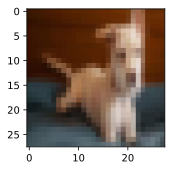

(28, 28)


In [267]:
# resized_imgs = [v2.Resize(size=size)(original_image) for size in (30, 50, 100, original_image.size)]
resized_imgs = v2.Resize(size=(28,28))(original_image)    # fornecendo apenas um valor para o size a dimensão é mantida.
plt.figure()
plt.imshow(resized_imgs)
plt.show()
print(resized_imgs.size)

In [268]:
trans = transforms.Compose([transforms.ToTensor()])
tensor_imag = trans(resized_imgs)
print(tensor_imag)
print(tensor_imag.shape)

tensor([[[0.2314, 0.2392, 0.2471,  ..., 0.3765, 0.3882, 0.4039],
         [0.2118, 0.2275, 0.2353,  ..., 0.4118, 0.4196, 0.4275],
         [0.1882, 0.2000, 0.2118,  ..., 0.3961, 0.4039, 0.4118],
         ...,
         [0.2118, 0.2392, 0.2588,  ..., 0.3294, 0.3451, 0.3216],
         [0.2353, 0.2510, 0.2706,  ..., 0.4039, 0.3686, 0.2784],
         [0.2431, 0.2588, 0.2745,  ..., 0.4039, 0.3255, 0.2471]],

        [[0.0941, 0.0980, 0.1020,  ..., 0.1647, 0.1725, 0.1686],
         [0.0902, 0.0980, 0.1020,  ..., 0.1804, 0.1843, 0.1843],
         [0.0627, 0.0745, 0.0824,  ..., 0.1686, 0.1647, 0.1686],
         ...,
         [0.2784, 0.3059, 0.3255,  ..., 0.3569, 0.3961, 0.3765],
         [0.3020, 0.3176, 0.3373,  ..., 0.4627, 0.4275, 0.3255],
         [0.3137, 0.3294, 0.3451,  ..., 0.4706, 0.3882, 0.2980]],

        [[0.0118, 0.0039, 0.0000,  ..., 0.0118, 0.0157, 0.0157],
         [0.0039, 0.0039, 0.0078,  ..., 0.0118, 0.0275, 0.0314],
         [0.0039, 0.0000, 0.0039,  ..., 0.0078, 0.0118, 0.

In [270]:
tensor_imag[0].shape


torch.Size([28, 28])

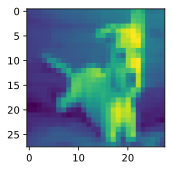

In [277]:
plt.imshow(tensor_imag[0])
plt.show()

In [278]:
pic = tensor_imag[0].unsqueeze(dim=0)
pic.shape

torch.Size([1, 28, 28])

In [279]:
# Doze primeiras camadas = todas as camadas
# saida = model.net[:12](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net(pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

torch.Size([1, 10])

In [280]:
saida

tensor([[ 1.3309, -1.4005,  0.0359,  0.6313,  1.0403, -3.7915,  2.3217, -1.9946,
          1.9048, -2.9214]], device='cuda:0', grad_fn=<AddmmBackward0>)

Todas as probabilidades são baixas, comparadas ao exercício anterior (1179.5236). Isto porque não conseguiu relacionar a figura do cachorro a nenhuma classificação.

--------------------------------------

torch.Size([6, 28, 28])

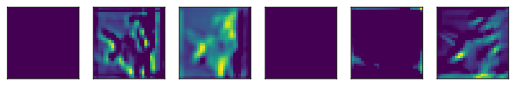

In [281]:
# Duas primeiras camadas
saida = model.net[:2](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,28,28),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 10, 10])

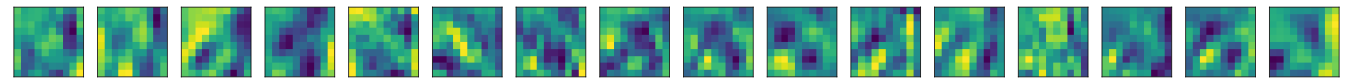

In [282]:
# Quatro primeiras camadas
saida = model.net[:4](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,10,10),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


# Código agrupado

acc: 0.86


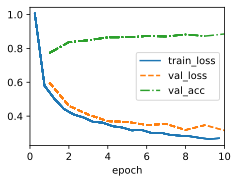

In [297]:
import numpy as np
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import v2

import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------
original_image = Image.open(Path('G:\\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\data\\FashionMNIST')
                            / 'meu_chinelo.jpeg')

resized_imgs = v2.Resize(size=(28,28))(original_image)    # fornecendo apenas um valor para o size a dimensão é mantida.
plt.figure()
plt.imshow(resized_imgs)
plt.show()
print(resized_imgs.size)

trans = transforms.Compose([transforms.ToTensor()])
tensor_imag = trans(resized_imgs)
print(tensor_imag)
print(tensor_imag.shape)

plt.imshow(tensor_imag[0])
plt.show()

pic = tensor_imag[0].unsqueeze(dim=0)
pic.shape

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------
class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Doze primeiras camadas = todas as camadas do LeNet
# saida = model.net[:12](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net(pic.unsqueeze(dim=0).cuda())           # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

# ------------------------------------------------------------------------------------
# CLASSIFICA A IMAGEM CONFORME A SAÍDA.
m = saida.max()                                        # saída máxima
idx_tensor = (saida==m).nonzero(as_tuple=True)[1]      # índice do tensor
indice = int(idx_tensor)                               # converte tensor para inteiro

list_chaves = []                                       # cria lista vazia
classificadores = data.val.class_to_idx                # dicionário de classificação do FashionMNIST
chaves = classificadores.keys()                        # Chaves do dicionário
for chave in chaves:
    list_chaves.append(chave)                          # Coloca as chaves em uma lista
classificacao = list_chaves[indice]                    # Busca o indice na lista
# ------------------------------------------------------------------------------------


In [298]:
saida


tensor([[ 1.1666, -0.2642,  1.2907, -2.1487, -3.3734, -0.6232,  0.9199, -2.0944,
          3.2608, -0.6462]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [299]:
classificacao

'Bag'

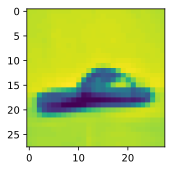

In [316]:
plt.imshow(tensor_imag[0])
plt.show()

 Como a imagem está numa resolução baixa (28x28), esta foi classificada como sendo uma bolsa, ao invés de um chinelo.

--------------------------------------------

--------------------------------------------

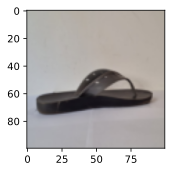

(100, 100)
tensor([[[0.6902, 0.6941, 0.6941,  ..., 0.6824, 0.6824, 0.6706],
         [0.6941, 0.6941, 0.6941,  ..., 0.6824, 0.6824, 0.6784],
         [0.6941, 0.6941, 0.6941,  ..., 0.6824, 0.6824, 0.6745],
         ...,
         [0.6667, 0.6627, 0.6627,  ..., 0.6667, 0.6667, 0.6627],
         [0.6627, 0.6627, 0.6627,  ..., 0.6627, 0.6667, 0.6627],
         [0.6667, 0.6667, 0.6667,  ..., 0.6627, 0.6588, 0.6627]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6510, 0.6510, 0.6431],
         [0.7020, 0.6980, 0.7020,  ..., 0.6510, 0.6510, 0.6471],
         [0.7020, 0.6980, 0.7020,  ..., 0.6510, 0.6510, 0.6471],
         ...,
         [0.6784, 0.6745, 0.6745,  ..., 0.6510, 0.6471, 0.6431],
         [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6431],
         [0.6784, 0.6745, 0.6745,  ..., 0.6431, 0.6431, 0.6431]],

        [[0.6784, 0.6745, 0.6745,  ..., 0.6078, 0.6078, 0.6000],
         [0.6824, 0.6745, 0.6784,  ..., 0.6078, 0.6078, 0.6000],
         [0.6824, 0.6784, 0.6824,  ..., 0.6078,

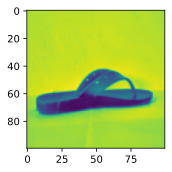

torch.Size([1, 100, 100])

In [302]:
resized_imgs = v2.Resize(size=(100,100))(original_image)    # fornecendo apenas um valor para o size a dimensão é mantida.
plt.figure()
plt.imshow(resized_imgs)
plt.show()
print(resized_imgs.size)

trans = transforms.Compose([transforms.ToTensor()])
tensor_imag = trans(resized_imgs)
print(tensor_imag)
print(tensor_imag.shape)

plt.imshow(tensor_imag[0])
plt.show()

pic = tensor_imag[0].unsqueeze(dim=0)
pic.shape


torch.Size([6, 100, 100])

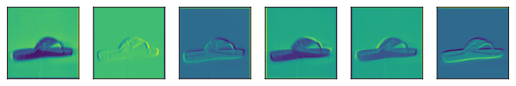

In [305]:
# Primeira camada
saida = model.net[0](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,100,100),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([6, 100, 100])

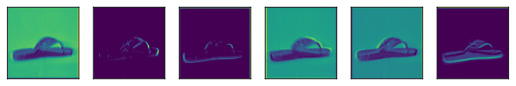

In [306]:
# Duas primeiras camadas
saida = model.net[:2](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,100,100),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([6, 50, 50])

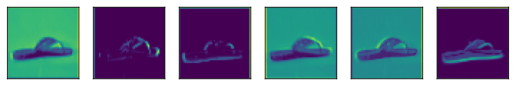

In [307]:
# Três primeiras camadas
saida = model.net[:3](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(6,50,50),1,6)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 46, 46])

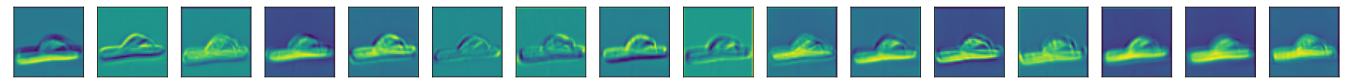

In [309]:
# Quatro primeiras camadas
saida = model.net[:4](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,46,46),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 46, 46])

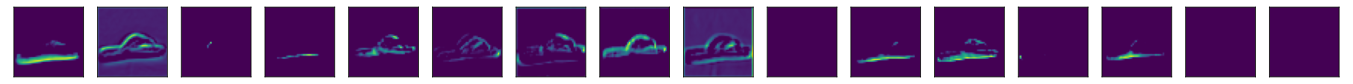

In [310]:
# Cinco primeiras camadas
saida = model.net[:5](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,46,46),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([16, 23, 23])

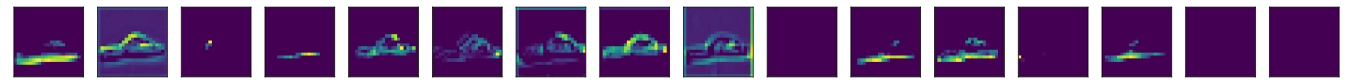

In [311]:
# Seis primeiras camadas
saida = model.net[:6](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,23,23),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.


torch.Size([1, 1, 8464])

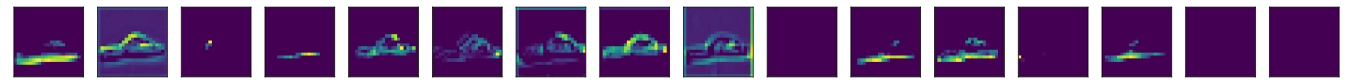

In [312]:
# Sete primeiras camadas
# saida = model.net[:7](pic.cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net[:7](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
d2l.show_images(saida.cpu().reshape(16,23,23),1,16)   # 2 imagens de 16@10x10
saida.shape   # Shape de Saída.
saida.unsqueeze(dim=0).shape

In [313]:
# Oito primeiras camadas
saida = model.net[:8](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8464 and 400x120)

# Código agrupado - Imagem: bota

acc: 0.83


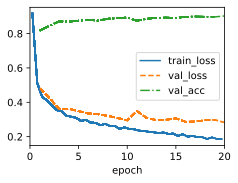

In [322]:
import numpy as np
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import v2

import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------
original_image = Image.open(Path('G:\\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\data\\FashionMNIST')
                            / 'minha_bota.jpeg')

resized_imgs = v2.Resize(size=(28,28))(original_image)    # fornecendo apenas um valor para o size a dimensão é mantida.
plt.figure()
plt.imshow(resized_imgs)
plt.show()
print(resized_imgs.size)

trans = transforms.Compose([transforms.ToTensor()])
tensor_imag = trans(resized_imgs)
print(tensor_imag)
print(tensor_imag.shape)

plt.imshow(tensor_imag[0])
plt.show()

pic = tensor_imag[0].unsqueeze(dim=0)
pic.shape

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:       # caso o módulo seja linear ou convolucional, realiza a inicialização Xavier.
        nn.init.xavier_uniform_(module.weight)                       # inicialização Xavier.

# ------------------------------------------------------------------------------------
class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):   # lr = learning rate
        super().__init__()                        # busca o .init() de d2l.Classifier.
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # Convolução
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                     #  <<--------------------------------------------------------
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

# ------------------------------------------------------------------------------------
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)                                                 # aplica a entrada X por cada camada em self.net = model.net
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()                                                      # cria o modelo
a = model.layer_summary((1, 1, 28, 28))                                  # verifica a arquitetura do modelo para o shape indicado (que será o shape de X)

# ------------------------------------------------------------------------------------
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)                           # treinador
data = d2l.FashionMNIST(batch_size=128)                                    # dados
model = LeNet(lr=0.1)                                                      # modelo
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)     # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)                                                   # início do treinamento

# ------------------------------------------------------------------------------------
# PEGAR y_hat e imprimir acc:
# ------------------------------------------------------------------------------------
# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
# y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1))
# print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')
# ------------------------------------------------------------------------------------
# SOLUÇÃO 2: transferir o dataset para a GPU.

# Verifica qual dispositivo está disponível: CPU ou GPU (cuda)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data.val.data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = model(val2.type(torch.float32).unsqueeze(dim=1))

targets2 = to_device(data.val.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {model.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Doze primeiras camadas = todas as camadas do LeNet
# saida = model.net[:12](pic.unsqueeze(dim=0).cuda())    # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida = model.net(pic.unsqueeze(dim=0).cuda())           # BASTA COLOCAR ENTRE PARÊNTESES A IMAGEM QUE DESEJA AVALIAR.
saida.shape   # Shape de Saída.

# ------------------------------------------------------------------------------------
# CLASSIFICA A IMAGEM CONFORME A SAÍDA.
m = saida.max()                                        # saída máxima
idx_tensor = (saida==m).nonzero(as_tuple=True)[1]      # índice do tensor
indice = int(idx_tensor)                               # converte tensor para inteiro

list_chaves = []                                       # cria lista vazia
classificadores = data.val.class_to_idx                # dicionário de classificação do FashionMNIST
chaves = classificadores.keys()                        # Chaves do dicionário
for chave in chaves:
    list_chaves.append(chave)                          # Coloca as chaves em uma lista
classificacao = list_chaves[indice]                    # Busca o indice na lista
# ------------------------------------------------------------------------------------


In [323]:
saida

tensor([[ 2.6383, -4.7490, -0.5534,  3.0499, -2.1737,  2.8525, -1.5016, -1.7374,
          0.3897,  0.7445]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [324]:
classificacao

'Dress'

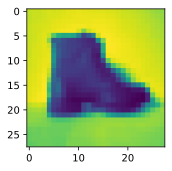

In [325]:
plt.imshow(tensor_imag[0])
plt.show()

# Referências

https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

https://www.philschmid.de/getting-started-with-cnn-by-calculating-lenet-layer-manually

https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/

https://github.com/lychengrex/LeNet-5-Implementation-Using-Pytorch/blob/master/LeNet-5%20Implementation%20Using%20Pytorch.ipynb

https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6